In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from MEDIC.secrets import controller

In [3]:
def get_delta_df(df, target: str):
    df = df.set_index(['date', 'CountryCode'])\
                .unstack(level=-1)\
                .diff(axis=0)\
                .unstack(level=0)\
                .reset_index()\
                .rename(columns={0: target})\
                .drop('level_0', axis=1)\
                .dropna()
    df['date'] = pd.to_datetime(df['date'])

    return df

In [4]:
confirmed_df = controller.get_df_from_sql("select CountryCode, date, confirmed "
                                          "from covid_info.COVID_Cases "
                                          "where SubdivisionCode is null and CountryCode != 'not found'")
confirmed_df = get_delta_df(confirmed_df, 'confirmed')

In [ ]:
# prepare dataset
window = 56
predict = 28

data_x = list()
data_y = list()

time_range = sorted(set(confirmed_df['date']))

for idx, country in enumerate(list(set(confirmed_df['CountryCode']))):
    cur_df = confirmed_df[confirmed_df['CountryCode'] == country]
    print('.', end='')

    for time_idx in range(len(time_range)-(window+predict) + 1):
        view_start_date = time_range[time_idx]
        view_end_date = time_range[time_idx+(window-1)]
        
        pred_start_date = time_range[time_idx+window]
        pred_end_date = time_range[time_idx+(window+predict-1)]
        
        data = cur_df[(view_start_date <= cur_df['date']) & (cur_df['date'] <= pred_end_date)]['confirmed'].to_list()
        data = np.array(data).reshape(-1, 1)
        
        scaler = preprocessing.StandardScaler().fit(data)
        scaled_data = scaler.transform(data)

        x = scaled_data.reshape(1, -1)[0][:window]
        y = scaled_data.reshape(1, -1)[0][window:window+predict]

        data_x.append(x)
        data_y.append(y)


In [ ]:
np_x = np.array(data_x)
np_y = np.array(data_y)

In [ ]:
print(np_x.shape)
print(np_y.shape)

In [ ]:
# reshaping
np_x = np_x.reshape(np_x.shape[0], np_x.shape[1], 1)
# np_y = np_y.reshape(np_y.shape[0], np_y.shape[1], 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size=0.2, shuffle=True, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, random_state=42)

In [ ]:
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

In [ ]:
batch_size = 128

In [ ]:
rnn_model = keras.Sequential()
# rnn_model.add(layers.Conv1D(filters=32, kernel_size=7, padding='SAME'))
# rnn_model.add(layers.Conv1D(filters=32, kernel_size=14, padding='SAME'))
# rnn_model.add(layers.Conv1D(filters=128, kernel_size=7, padding='SAME'))
rnn_model.add(layers.LSTM(units=32, activation='relu', return_sequences=False, input_shape=(window, 1)))

rnn_model.add(layers.Dropout(rate=0.2))

rnn_model.add(layers.Dense(64))
rnn_model.add(layers.Dense(32))
rnn_model.add(layers.Dense(predict))

rnn_model.summary()


In [ ]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습과정 설정 
rnn_model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae', 'mape'])

# 모델 트레이닝 
hist = rnn_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=batch_size, callbacks=[early_stopping])

In [ ]:
import matplotlib.pyplot as plt
history = hist
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for mape
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
from random import randint
idx = randint(0, len(x_test))
pred = rnn_model.predict(x_test[idx].reshape(1, window, 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(y_test[idx], label = 'actual')
plt.plot(pred.reshape(-1, 1), label = 'prediction')
plt.legend()
plt.show()

In [5]:
from random import randint
idx = randint(0, len(x_test))
pred = rnn_model.predict(x_test[idx].reshape(1, window, 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(y_test[idx], label = 'actual')
plt.plot(pred.reshape(-1, 1), label = 'prediction')
plt.legend()
plt.show()

................................................................................................................................................................................................

In [6]:
np_x = np.array(data_x)
np_y = np.array(data_y)

In [7]:
print(np_x.shape)
print(np_y.shape)

(87360, 56)
(87360, 28)


In [8]:
# reshaping
np_x = np_x.reshape(np_x.shape[0], np_x.shape[1], 1)
# np_y = np_y.reshape(np_y.shape[0], np_y.shape[1], 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size=0.2, shuffle=True, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, random_state=42)

In [10]:
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(52416, 56, 1) (17472, 56, 1) (17472, 56, 1)
(52416, 28) (17472, 28) (17472, 28)


In [11]:
batch_size = 128

In [35]:
rnn_model = keras.Sequential()
# rnn_model.add(layers.Conv1D(filters=32, kernel_size=7, padding='SAME'))
# rnn_model.add(layers.Conv1D(filters=32, kernel_size=14, padding='SAME'))
# rnn_model.add(layers.Conv1D(filters=128, kernel_size=7, padding='SAME'))
rnn_model.add(layers.LSTM(units=32, activation='relu', return_sequences=False, input_shape=(window, 1)))

rnn_model.add(layers.Dropout(rate=0.2))

rnn_model.add(layers.Dense(64))
rnn_model.add(layers.Dense(32))
rnn_model.add(layers.Dense(predict))

rnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 28)                924       
Total params: 9,468
Trainable params: 9,468
Non-trainable params: 0
_________________________________________________________________


In [36]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습과정 설정 
rnn_model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae', 'mape'])

# 모델 트레이닝 
hist = rnn_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/100
410/410 [==============================] - 17s 37ms/step - loss: 1.3404 - acc: 0.0760 - mae: 0.7550 - mape: 5511046.4587 - val_loss: 0.7218 - val_acc: 0.1060 - val_mae: 0.5601 - val_mape: 3512721.0000
Epoch 2/100
410/410 [==============================] - 19s 46ms/step - loss: 0.7308 - acc: 0.1081 - mae: 0.5701 - mape: 3490783.0669 - val_loss: 0.6850 - val_acc: 0.1173 - val_mae: 0.5277 - val_mape: 2847053.5000
Epoch 3/100
410/410 [==============================] - 29s 71ms/step - loss: 0.7046 - acc: 0.1155 - mae: 0.5472 - mape: 3753176.9264 - val_loss: 0.6798 - val_acc: 0.1184 - val_mae: 0.5225 - val_mape: 2383130.7500
Epoch 4/100
410/410 [==============================] - 32s 78ms/step - loss: 0.6959 - acc: 0.1141 - mae: 0.5395 - mape: 3268391.7917 - val_loss: 0.6782 - val_acc: 0.1261 - val_mae: 0.5163 - val_mape: 2807670.5000
Epoch 5/100
410/410 [==============================] - 23s 57ms/step - loss: 0.6913 - acc: 0.1135 - mae: 0.5370 - mape: 3055068.7506 - val_loss: 0.6

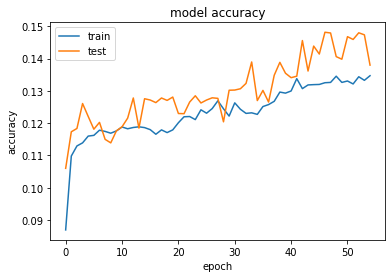

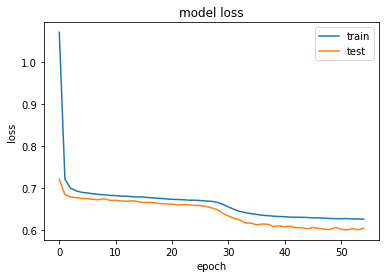

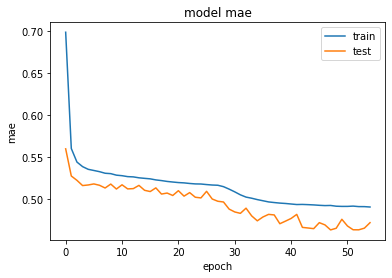

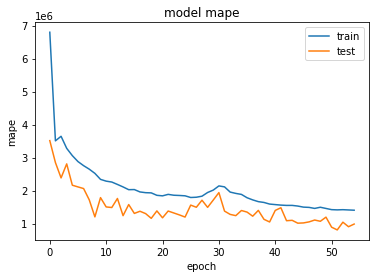

In [37]:
import matplotlib.pyplot as plt
history = hist
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for mape
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

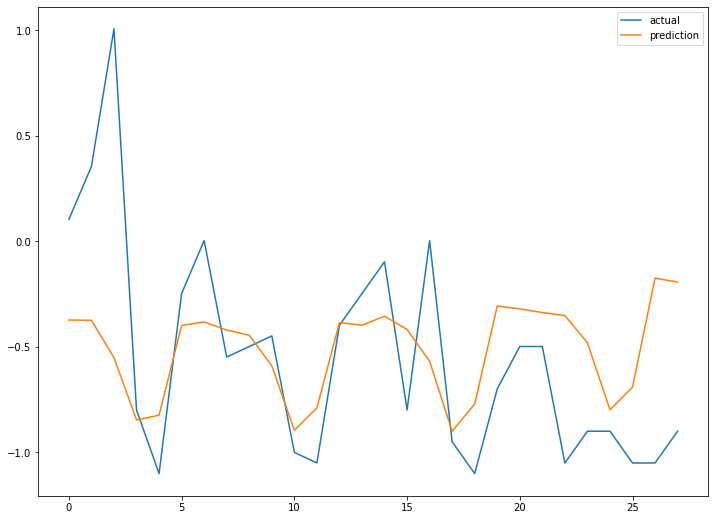

In [41]:
from random import randint
idx = randint(0, len(x_test))
pred = rnn_model.predict(x_test[idx].reshape(1, window, 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(y_test[idx], label = 'actual')
plt.plot(pred.reshape(-1, 1), label = 'prediction')
plt.legend()
plt.show()